# Practical Time Series Analysis

## Week 6: SARIMA, Forecasting

**1. SARIMA**

**2. Forecasting**

In [30]:
library(astsa)
library(tsdl)
library(forecast)

## 1. SARIMA

### 1.1. SARIMA Context

**Box-Jenkins Seasonal ARIMA Model**

* Data might contain seasonal periodic component in addition to correlation with recent lags
* It repeats every $s$ observations
* For a time series of monthly observations, $X_t$ might depend on annual lags
* $X_{t-12}, X_{t-24}, ...$
* Quartely data might have period of $s = 4$
* Seasonal ARIMA model

**Pure Seasonal ARMA process**

ARMA$(P, Q)_s$ has the form

$\Phi(B^s) X_t = \Theta_q (B^s) Z_t$

where

$\Phi_P(B^s) = 1 - \Phi_1 B^s - \Phi_2 B^{2s} - ... - \Phi_P B^{Ps}$

and

$\Phi_Q(B^s) = 1 + \Theta_1 B^s + \Theta_2 B^{2s} + ... + \Theta_Q B^{Qs}$

**Example 1**

Seasonal ARMA$(1,0)_{12}$ has the form

$(1 - \Phi_1 B^{12}) X_t = Z_t$

i.e.

$X_t = \Phi_1 X_{t-12} + Z_t$

**Seasonal ARIMA process (SARIMA)**

SARIMA$(p, d, q, P, D, Q)_s$ has the form

$\Phi_P (B^s) \phi_p (B) (1 - B^S)^D (1 - B)^d X_t = \Theta_Q (B^s) \theta_q (B) Z_t$

where capital letters refer to the order of the seasonal part.

SARIMA$(p, d, q, P, D, Q)_s$ has two parts: Non-seasonal part $(p,d,q)$ and seasonal parts $(P, D, Q)_s$.

1. p - order of non-seasonal AR terms
2. d - order of non-seasonal differencing
3. q - order of non-seasonal MA terms
4. P - order of seasonal AR (i.e., SAR) terms
5. D - order of seasonal differencing (i.e., power of $(1-B^s)$)
6. Q - order of seasonal MA (i.e., SMA) terms

### 1.2. SARIMA ACF

**Example - SARIMA$(0, 0, 1, 0, 0, 1)_{12}$**

$X_t = (1 + \Theta_1 B^{12}) (1 + \theta_1 B) Z_t$

Thus

$X_t = Z_t + \theta_1 Z_{t-1} + \Theta_1 Z_{t-12} + \theta_1 \Theta_1 Z_{t-13}$

Choose $\theta1 = 0.7$, $\Theta_1 = 0.6$, then:

$X_t = Z_t + 0.7 Z_{t-1} + 0.6 Z_{t-12} + 0.42 Z_{t-13}$

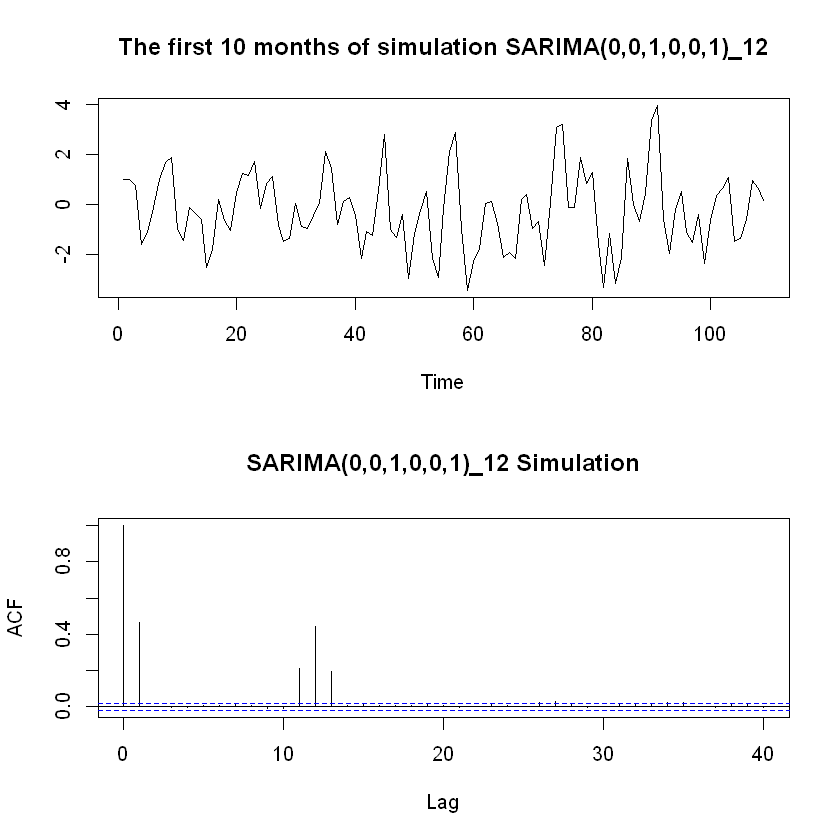

In [4]:
x=NULL
z=NULL
n=10000

z=rnorm(n)
x[1:13]=1

for(i in 14:n){
  x[i]<-z[i]+0.7*z[i-1]+0.6*z[i-12]+0.42*z[i-13]
}

par(mfrow=c(2,1))
plot.ts(x[12:120], main='The first 10 months of simulation SARIMA(0,0,1,0,0,1)_12', ylab='') 

acf(x, main='SARIMA(0,0,1,0,0,1)_12 Simulation')

### 1.3. Johnson & Johnson

**Modelling**

1. Time plot
2. Transformation
3. Differencing (seasonal or non-seasonal)
4. Ljung-Box test
5. ACF $\rightarrow$ Closers spikes $\rightarrow$ MA order
6. ACF $\rightarrow$ Spikes around seasonal lags $\rightarrow$ SMA order
7. PACF $\rightarrow$ Closers spikes $\rightarrow$ AR order
8. PACF $\rightarrow$ Spikes around seasonal lags $\rightarrow$ SAR order
9. Fit few different models
10. Compare AIC, choose a model with minimun AIC
11. The parsimony principle (choose the simplest model, heuristic: $p + d + q + P + D + Q \leq 6$)
12. Time plot, ACF and PACF of residuals
13. Ljung-Box test for residuals

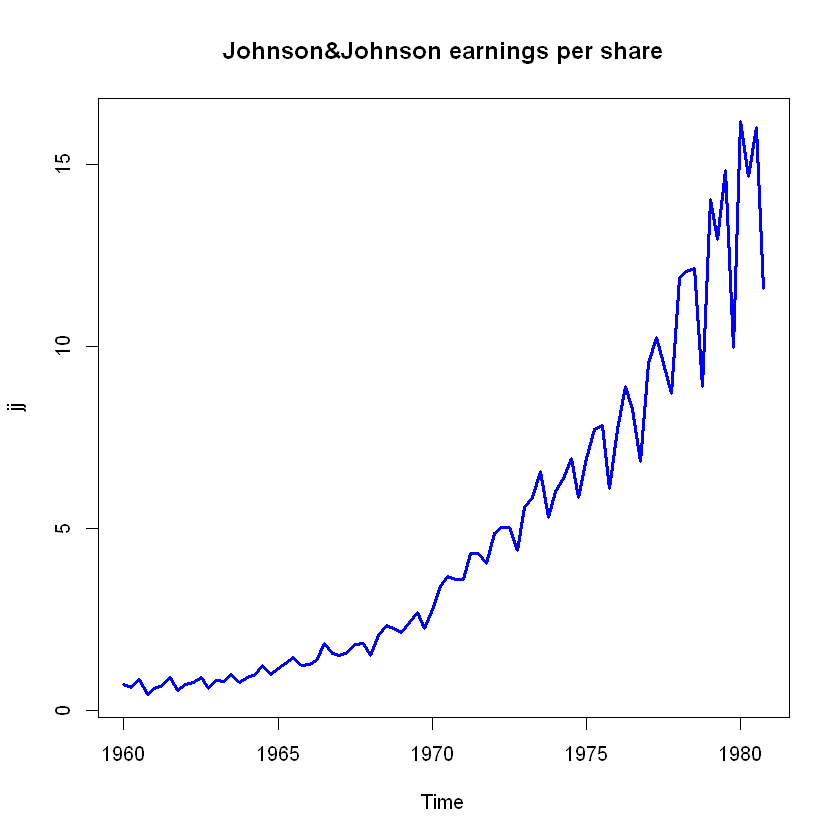

In [18]:
# Time plot for Johnson&Johnson
jj = JohnsonJohnson
plot(jj, main='Johnson&Johnson earnings per share', col='blue', lwd=3)

In [19]:
# log-return of Johnson&Johnson
jj.log.return=diff(log(jj))
jj.log.return.mean.zero=jj.log.return-mean(jj.log.return)

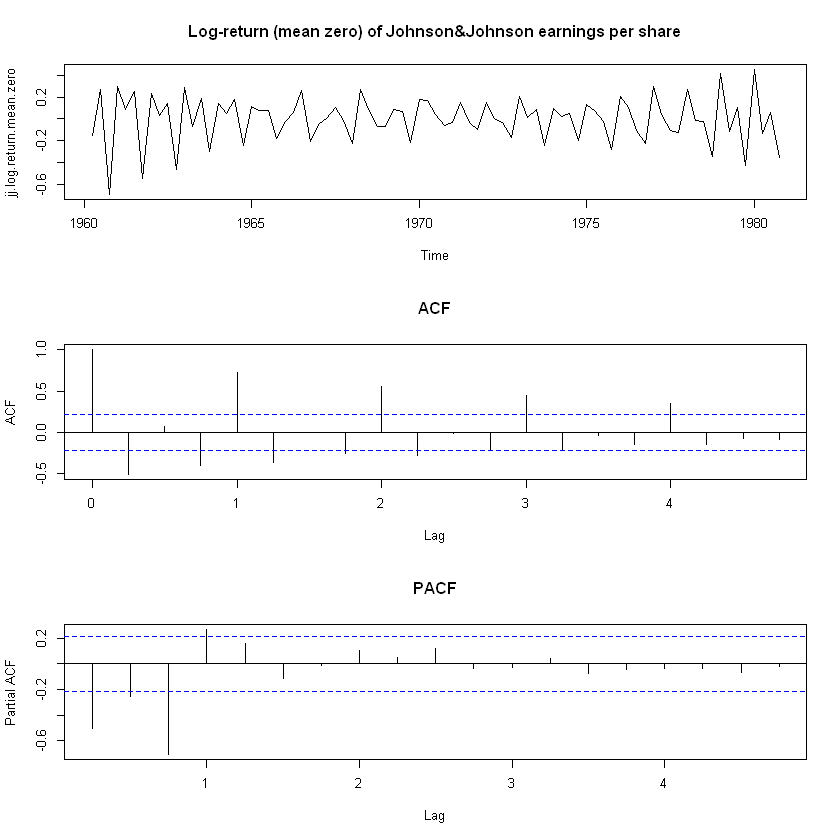

In [20]:
# Plots for log-returns
par(mfrow=c(3,1))
plot(jj.log.return.mean.zero, main='Log-return (mean zero) of Johnson&Johnson earnings per share')
acf(jj.log.return.mean.zero, main='ACF')
pacf(jj.log.return.mean.zero, main='PACF')

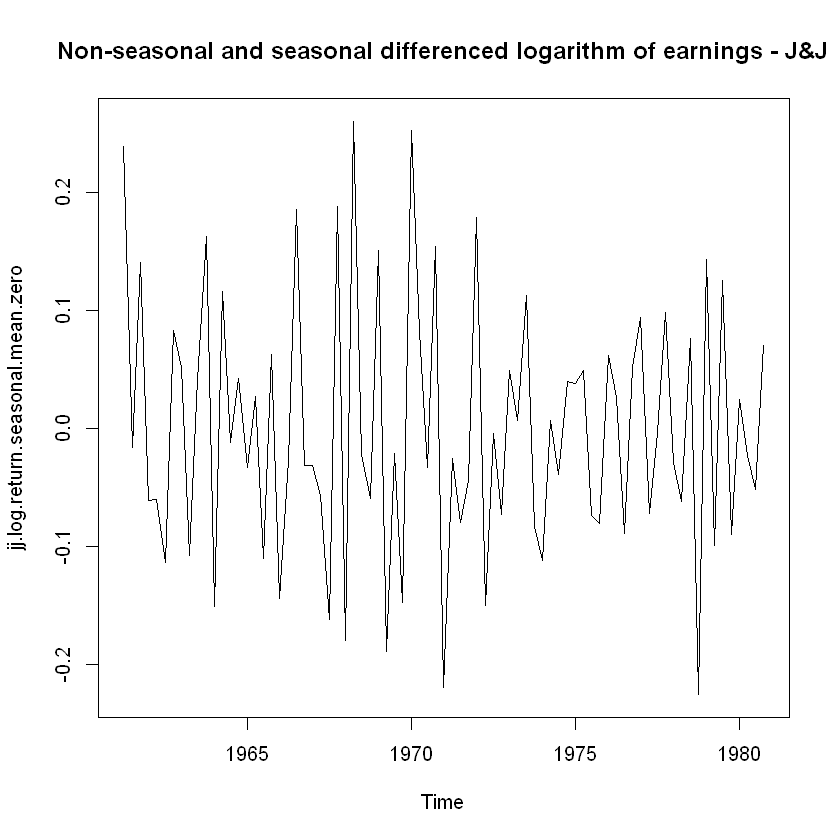

In [11]:
# seasonal diff
jj.log.return.seasonal=diff(jj.log.return, 4)
jj.log.return.seasonal.mean.zero=jj.log.return.seasonal-mean(jj.log.return.seasonal)

# Plots for log-returns
plot(jj.log.return.seasonal.mean.zero, main='Non-seasonal and seasonal differenced logarithm of earnings - J&J')

In [15]:
# Ljung-Box test
Box.test(jj.log.return.seasonal.mean.zero, lag = log(length(jj.log.return.seasonal.mean.zero)))


	Box-Pierce test

data:  jj.log.return.seasonal.mean.zero
X-squared = 20.95, df = 4.3694, p-value = 0.0004658


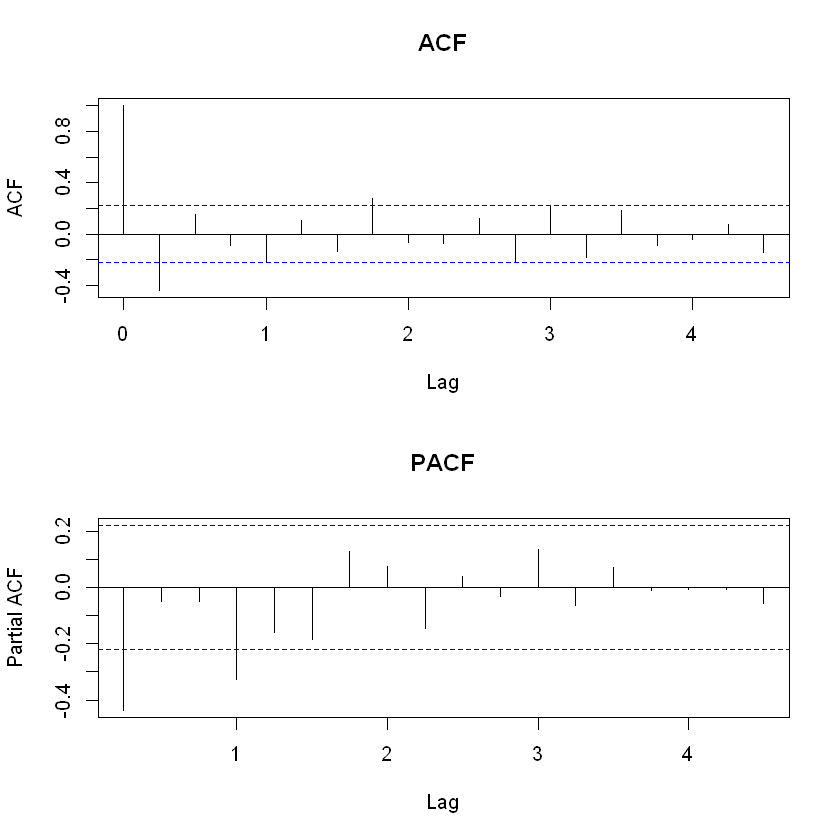

In [17]:
# ACF and PACF for detrended data
par(mfrow=c(2,1))
acf(jj.log.return.seasonal.mean.zero, main='ACF')
pacf(jj.log.return.seasonal.mean.zero, main='PACF')

In [21]:
d=1
DD=1

per=4

for(p in 1:2){
  for(q in 1:2){
    for(i in 1:2){
      for(j in 1:2){
        if(p+d+q+i+DD+j<=10){
          model<-arima(x=log(jj), order = c((p-1),d,(q-1)), seasonal = list(order=c((i-1),DD,(j-1)), period=per))
          pval<-Box.test(model$residuals, lag=log(length(model$residuals)))
          sse<-sum(model$residuals^2)
          cat(p-1,d,q-1,i-1,DD,j-1,per, 'AIC=', model$aic, ' SSE=',sse,' p-VALUE=', pval$p.value,'\n')
        }
      }
    }
  }
}

0 1 0 0 1 0 4 AIC= -124.0685  SSE= 0.9377872  p-VALUE= 0.0002610792 
0 1 0 0 1 1 4 AIC= -126.3493  SSE= 0.8856995  p-VALUE= 0.0001606501 
0 1 0 1 1 0 4 AIC= -125.9198  SSE= 0.8908546  p-VALUE= 0.0001978113 
0 1 0 1 1 1 4 AIC= -124.3648  SSE= 0.8854555  p-VALUE= 0.0001574029 
0 1 1 0 1 0 4 AIC= -145.5139  SSE= 0.6891989  p-VALUE= 0.03543717 
0 1 1 0 1 1 4 AIC= -150.7528  SSE= 0.6265214  p-VALUE= 0.6089542 
0 1 1 1 1 0 4 AIC= -150.9134  SSE= 0.6251635  p-VALUE= 0.7079173 
0 1 1 1 1 1 4 AIC= -149.1317  SSE= 0.6232876  p-VALUE= 0.6780876 
1 1 0 0 1 0 4 AIC= -139.8248  SSE= 0.7467495  p-VALUE= 0.03503386 
1 1 0 0 1 1 4 AIC= -146.0191  SSE= 0.6692692  p-VALUE= 0.5400206 
1 1 0 1 1 0 4 AIC= -146.0319  SSE= 0.6689661  p-VALUE= 0.5612965 
1 1 0 1 1 1 4 AIC= -144.3766  SSE= 0.6658382  p-VALUE= 0.5459446 
1 1 1 0 1 0 4 AIC= -145.8284  SSE= 0.667109  p-VALUE= 0.2200492 
1 1 1 0 1 1 4 AIC= -148.7706  SSE= 0.6263678  p-VALUE= 0.594822 
1 1 1 1 1 0 4 AIC= -148.9175  SSE= 0.6251104  p-VALUE= 0.7195471

initial  value -2.237259 
iter   2 value -2.429075
iter   3 value -2.446737
iter   4 value -2.455821
iter   5 value -2.459761
iter   6 value -2.462511
iter   7 value -2.462602
iter   8 value -2.462749
iter   9 value -2.462749
iter   9 value -2.462749
iter   9 value -2.462749
final  value -2.462749 
converged
initial  value -2.411490 
iter   2 value -2.412022
iter   3 value -2.412060
iter   4 value -2.412062
iter   4 value -2.412062
iter   4 value -2.412062
final  value -2.412062 
converged


$fit

Call:
stats::arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, 
    Q), period = S), include.mean = !no.constant, transform.pars = trans, fixed = fixed, 
    optim.control = list(trace = trc, REPORT = 1, reltol = tol))

Coefficients:
          ma1     sar1
      -0.6796  -0.3220
s.e.   0.0969   0.1124

sigma^2 estimated as 0.007913:  log likelihood = 78.46,  aic = -150.91

$degrees_of_freedom
[1] 77

$ttable
     Estimate     SE t.value p.value
ma1   -0.6796 0.0969 -7.0104  0.0000
sar1  -0.3220 0.1124 -2.8641  0.0054

$AIC
[1] -1.840408

$AICc
[1] -1.838555

$BIC
[1] -1.753721


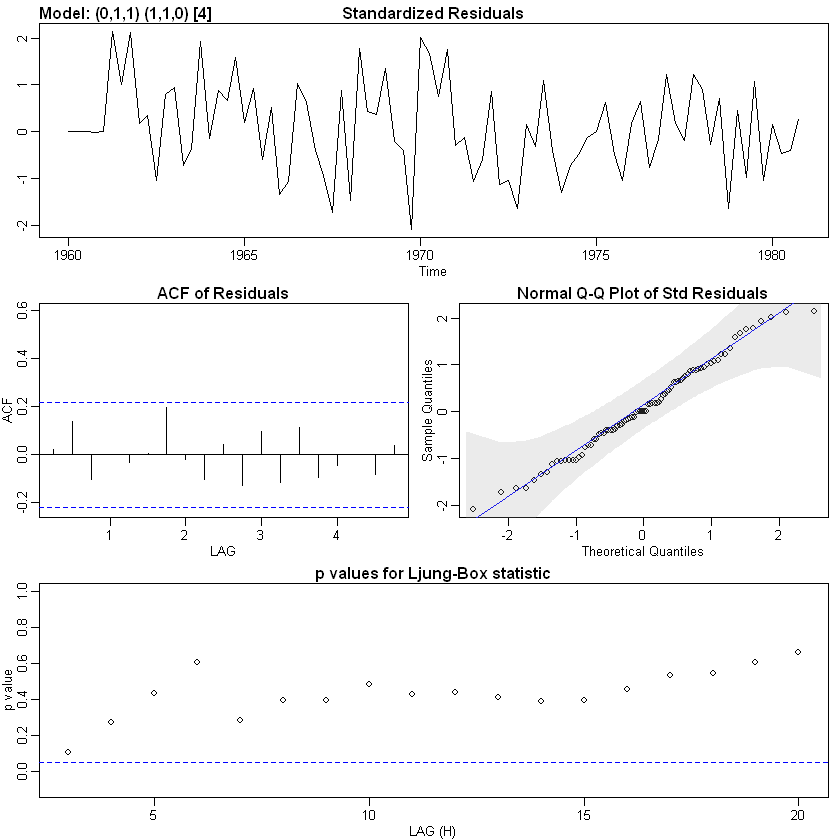

In [22]:
sarima(log(jj), 0,1,1,1,1,0,4)

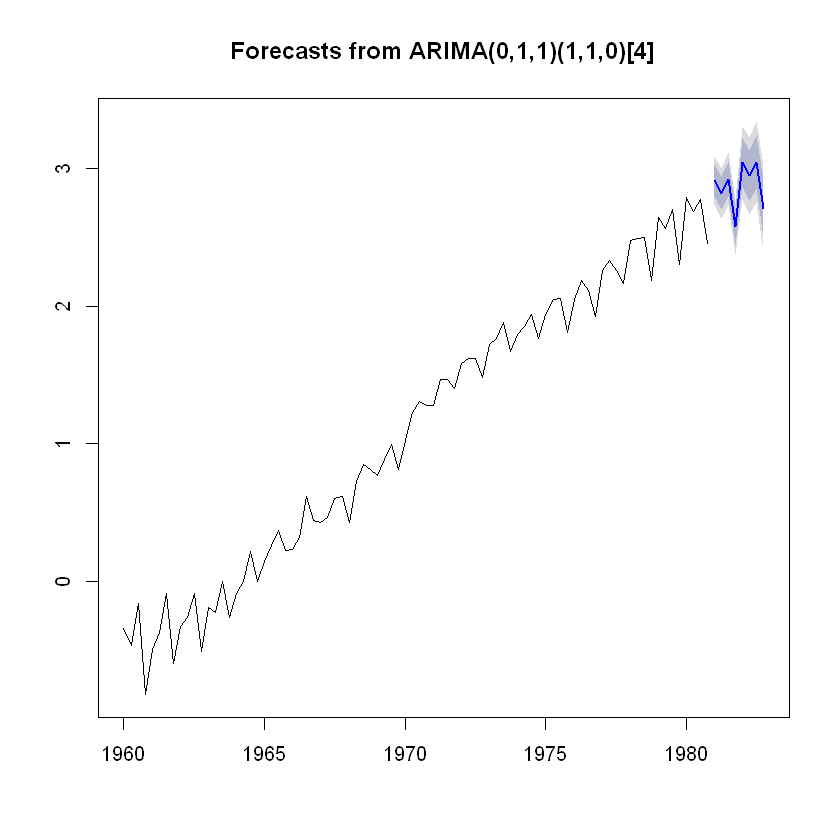

In [27]:
# forecast
model = arima(log(jj), order = c(0,1,1), seasonal = list(order = c(1,1,0), period = 4))
plot(forecast(model))

### 1.4. Milk Production

In [29]:
milk = read.csv('../data/monthly-milk-production-pounds-p.csv')
Milk = milk$Pounds

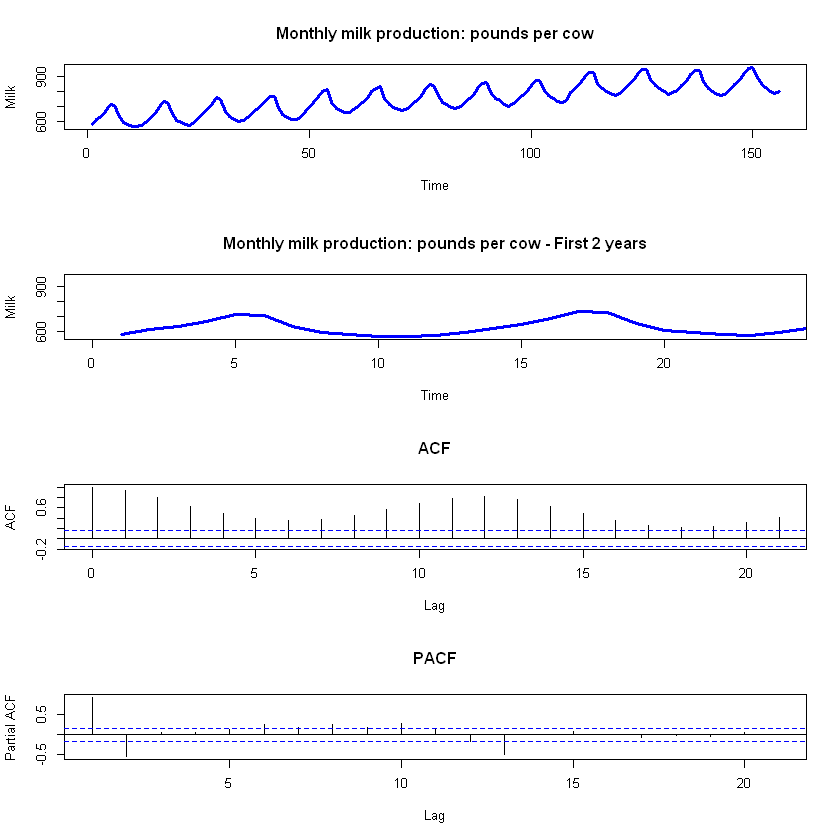

In [63]:
par(mfrow=c(4,1))
plot.ts(Milk, col='blue', lwd=3, main = "Monthly milk production: pounds per cow")
plot.ts(Milk, col='blue', lwd=3, main = "Monthly milk production: pounds per cow - First 2 years", xlim = c(0, 24))

# ACF and PACF for Milk data
acf(Milk, main='ACF')
pacf(Milk, main='PACF')

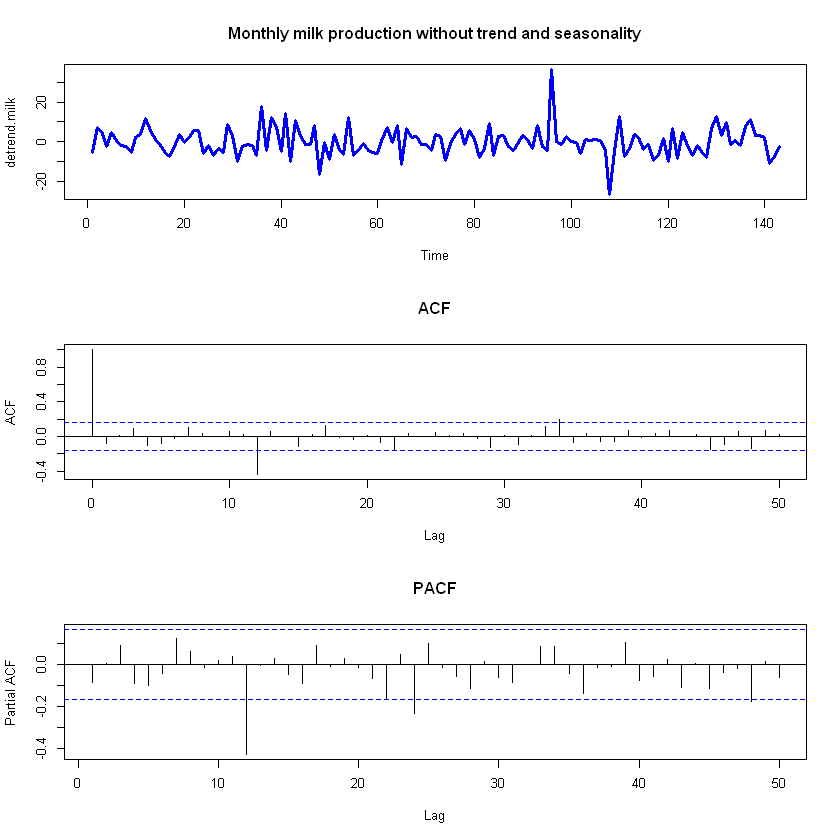

In [64]:
par(mfrow=c(3,1))
detrend.milk = diff(diff(Milk), 12)
plot.ts(detrend.milk, col='blue', lwd=3, main = "Monthly milk production without trend and seasonality")

# ACF and PACF for detrended Milk data
acf(detrend.milk, main='ACF', lag = 50)
pacf(detrend.milk, main='PACF', lag = 50)

In [54]:
d=NULL
DD=NULL
d=1
DD=1

per=12
for(p in 1:1){
  for(q in 1:1){
    for(i in 1:3){
      for(j in 1:4){
        if(p+d+q+i+DD+j<=10){
          model<-arima(x=Milk, order = c((p-1),d,(q-1)), seasonal = list(order=c((i-1),DD,(j-1)), period=per))
          pval<-Box.test(model$residuals, lag=log(length(model$residuals)))
          sse<-sum(model$residuals^2)
          cat(p-1,d,q-1,i-1,DD,j-1,per, 'AIC=', model$aic, ' SSE=',sse,' p-VALUE=', pval$p.value,'\n')
        }
      }
    }
  }
}

0 1 0 0 1 0 12 AIC= 968.3966  SSE= 7213.013  p-VALUE= 0.4393367 
0 1 0 0 1 1 12 AIC= 923.3288  SSE= 4933.349  p-VALUE= 0.6493728 
0 1 0 0 1 2 12 AIC= 925.3072  SSE= 4931.398  p-VALUE= 0.6529998 
0 1 0 0 1 3 12 AIC= 927.2329  SSE= 4925.911  p-VALUE= 0.6640233 
0 1 0 1 1 0 12 AIC= 938.6402  SSE= 5668.197  p-VALUE= 0.493531 
0 1 0 1 1 1 12 AIC= 925.3063  SSE= 4931.428  p-VALUE= 0.6531856 
0 1 0 1 1 2 12 AIC= 927.3036  SSE= 4931.135  p-VALUE= 0.6537708 
0 1 0 1 1 3 12 AIC= 929.2146  SSE= 4924.747  p-VALUE= 0.6627108 
0 1 0 2 1 0 12 AIC= 932.6438  SSE= 5308.012  p-VALUE= 0.6004804 
0 1 0 2 1 1 12 AIC= 927.2797  SSE= 4929.733  p-VALUE= 0.657349 
0 1 0 2 1 2 12 AIC= 926.8053  SSE= 4618.498  p-VALUE= 0.6826743 


initial  value 1.960071 
iter   2 value 1.820277
iter   3 value 1.808696
iter   4 value 1.803385
iter   5 value 1.802687
iter   6 value 1.800218
iter   7 value 1.800130
iter   8 value 1.800128
iter   9 value 1.800127
iter   9 value 1.800127
iter   9 value 1.800127
final  value 1.800127 
converged
initial  value 1.797249 
iter   2 value 1.795522
iter   3 value 1.795498
iter   4 value 1.795498
iter   4 value 1.795498
final  value 1.795498 
converged


$fit

Call:
stats::arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, 
    Q), period = S), include.mean = !no.constant, transform.pars = trans, fixed = fixed, 
    optim.control = list(trace = trc, REPORT = 1, reltol = tol))

Coefficients:
         sma1
      -0.6750
s.e.   0.0752

sigma^2 estimated as 34.47:  log likelihood = -459.66,  aic = 923.33

$degrees_of_freedom
[1] 142

$ttable
     Estimate     SE t.value p.value
sma1   -0.675 0.0752 -8.9785       0

$AIC
[1] 5.995642

$AICc
[1] 5.995812

$BIC
[1] 6.03412


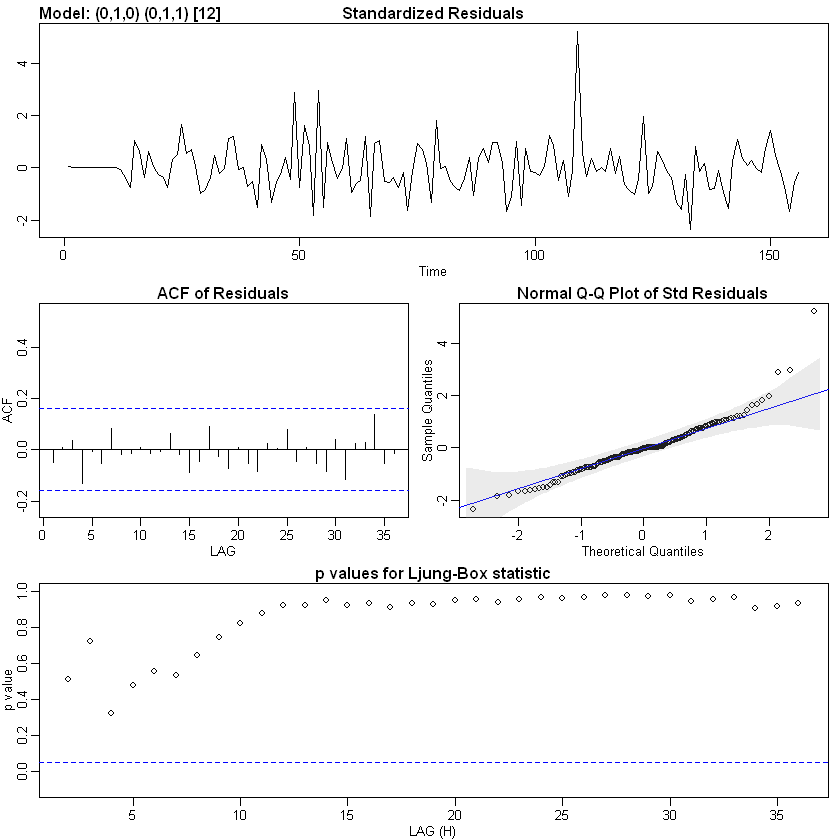

In [55]:
sarima(Milk, 0,1,0,0,1,1,12)

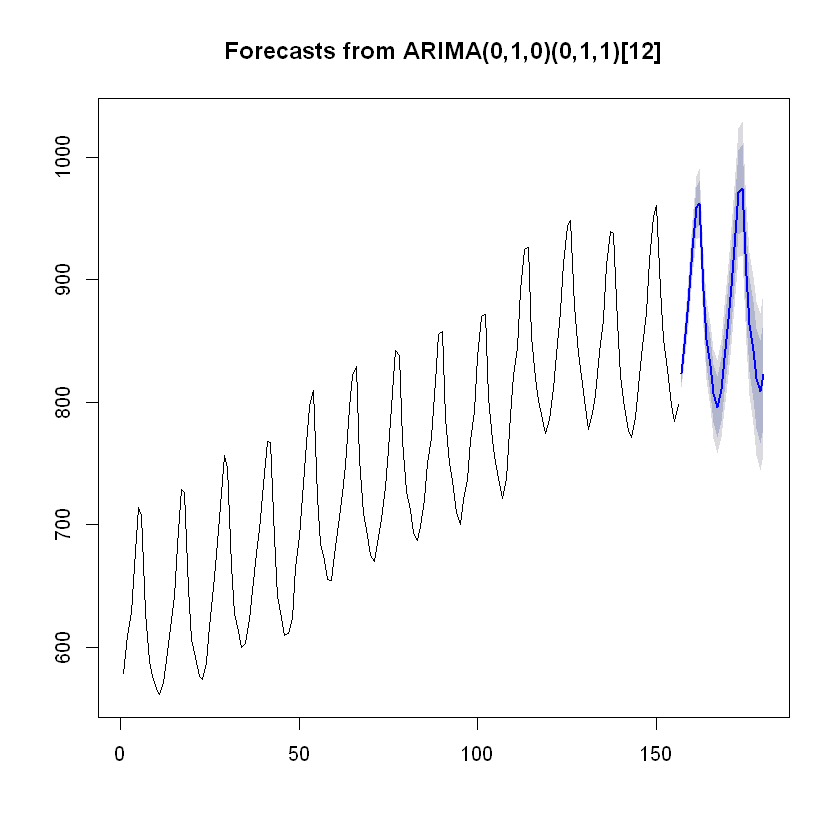

In [56]:
# forecast
model = arima(x=Milk, order = c(0,1,0), seasonal = list(order=c(0,1,1), period=12))
plot(forecast(model))

### 1.4. Sales at a souvenir shop

In [58]:
SUV = read.csv('../data/monthly-sales-for-a-souvenir-sho.csv')
suv = ts(SUV$Sales)

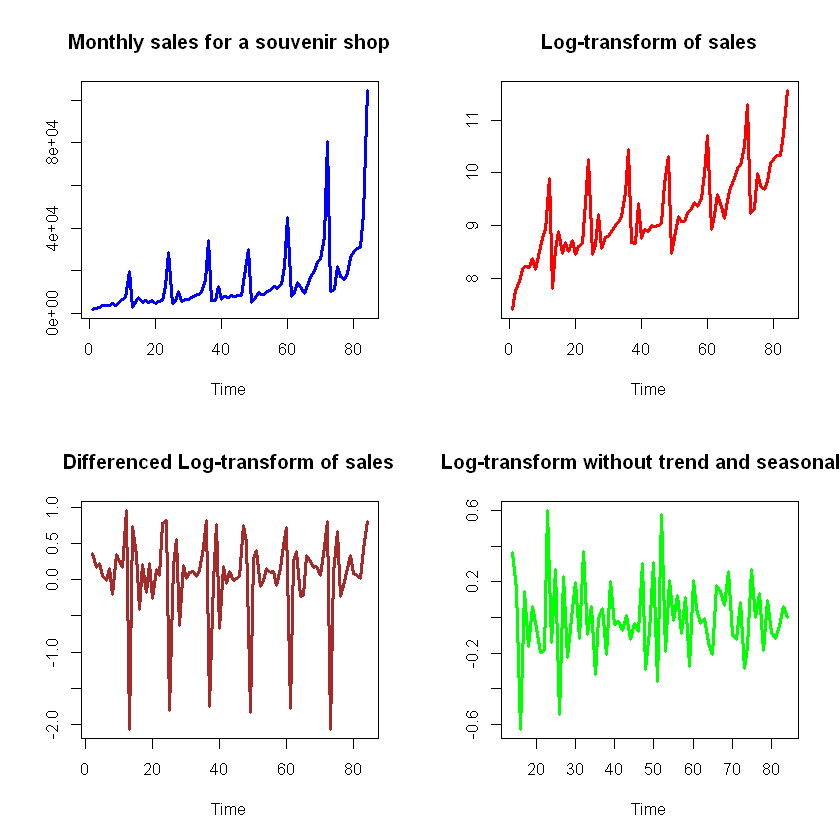

In [68]:
par(mfrow=c(2,2))

plot(suv, main='Monthly sales for a souvenir shop', ylab='', col='blue', lwd=3)
plot(log(suv), main='Log-transform of sales', ylab='', col='red', lwd=3)
plot(diff(log(suv)), main='Differenced Log-transform of sales', ylab='', col='brown', lwd=3)
plot(diff(diff(log(suv)),12), main='Log-transform without trend and seasonaliy', ylab='', col='green', lwd=3)

ACF,PACF
-0.46,-0.46
0.19,-0.02
-0.17,-0.11
-0.06,-0.23
0.01,-0.13
0.00,-0.07
-0.07,-0.20
0.07,-0.12
0.09,0.11
0.02,0.11


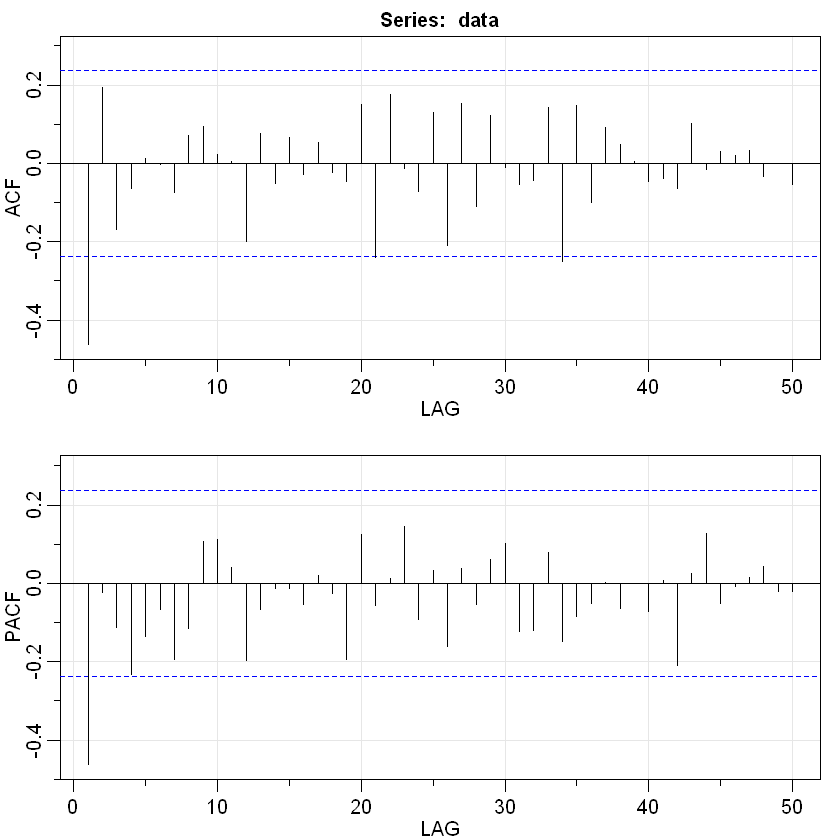

In [67]:
# detrend and acf
data = diff(diff((log(suv)),12))
acf2(data, 50)

In [69]:
d=1
DD=1
per=12
for(p in 1:2){
  for(q in 1:2){
    for(i in 1:2){
      for(j in 1:4){
        if(p+d+q+i+DD+j<=10){
          model<-arima(x=log(suv), order = c((p-1),d,(q-1)), seasonal = list(order=c((i-1),DD,(j-1)), period=per))
          pval<-Box.test(model$residuals, lag=log(length(model$residuals)))
          sse<-sum(model$residuals^2)
          cat(p-1,d,q-1,i-1,DD,j-1,per, 'AIC=', model$aic, ' SSE=',sse,' p-VALUE=', pval$p.value,'\n')
        }
      }
    }
  }
}

0 1 0 0 1 0 12 AIC= -11.60664  SSE= 3.432906  p-VALUE= 0.0001365566 
0 1 0 0 1 1 12 AIC= -16.09179  SSE= 2.97756  p-VALUE= 3.149952e-05 
0 1 0 0 1 2 12 AIC= -17.58234  SSE= 2.301963  p-VALUE= 0.0002456591 
0 1 0 0 1 3 12 AIC= -16.41016  SSE= 2.35266  p-VALUE= 0.0003392283 
0 1 0 1 1 0 12 AIC= -13.43083  SSE= 3.214065  p-VALUE= 4.083839e-05 
0 1 0 1 1 1 12 AIC= -17.76362  SSE= 2.399746  p-VALUE= 0.0001916565 
0 1 0 1 1 2 12 AIC= -15.99095  SSE= 2.349897  p-VALUE= 0.0002477782 
0 1 0 1 1 3 12 AIC= -14.74777  SSE= 2.302026  p-VALUE= 0.0004504601 
0 1 1 0 1 0 12 AIC= -27.78538  SSE= 2.643277  p-VALUE= 0.1742478 
0 1 1 0 1 1 12 AIC= -34.54538  SSE= 2.233424  p-VALUE= 0.2730783 
0 1 1 0 1 2 12 AIC= -33.6145  SSE= 2.109473  p-VALUE= 0.2830597 
0 1 1 0 1 3 12 AIC= -32.19273  SSE= 1.87789  p-VALUE= 0.270042 
0 1 1 1 1 0 12 AIC= -32.33192  SSE= 2.360507  p-VALUE= 0.2584529 
0 1 1 1 1 1 12 AIC= -34.0881  SSE= 1.842013  p-VALUE= 0.2843225 
0 1 1 1 1 2 12 AIC= -32.1017  SSE= 1.856342  p-VALUE= 0.28

initial  value -1.527727 
iter   2 value -1.675635
iter   3 value -1.682326
iter   4 value -1.682437
iter   5 value -1.682439
iter   5 value -1.682439
iter   5 value -1.682439
final  value -1.682439 
converged
initial  value -1.692103 
iter   2 value -1.704334
iter   3 value -1.707567
iter   4 value -1.707595
iter   5 value -1.707595
iter   5 value -1.707595
iter   5 value -1.707595
final  value -1.707595 
converged


$fit

Call:
stats::arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, 
    Q), period = S), include.mean = !no.constant, transform.pars = trans, fixed = fixed, 
    optim.control = list(trace = trc, REPORT = 1, reltol = tol))

Coefficients:
          ar1     sma1
      -0.5017  -0.5107
s.e.   0.1013   0.1543

sigma^2 estimated as 0.03111:  log likelihood = 20.49,  aic = -34.99

$degrees_of_freedom
[1] 69

$ttable
     Estimate     SE t.value p.value
ar1   -0.5017 0.1013 -4.9531  0.0000
sma1  -0.5107 0.1543 -3.3098  0.0015

$AIC
[1] -0.4266974

$AICc
[1] -0.4248449

$BIC
[1] -0.3439164


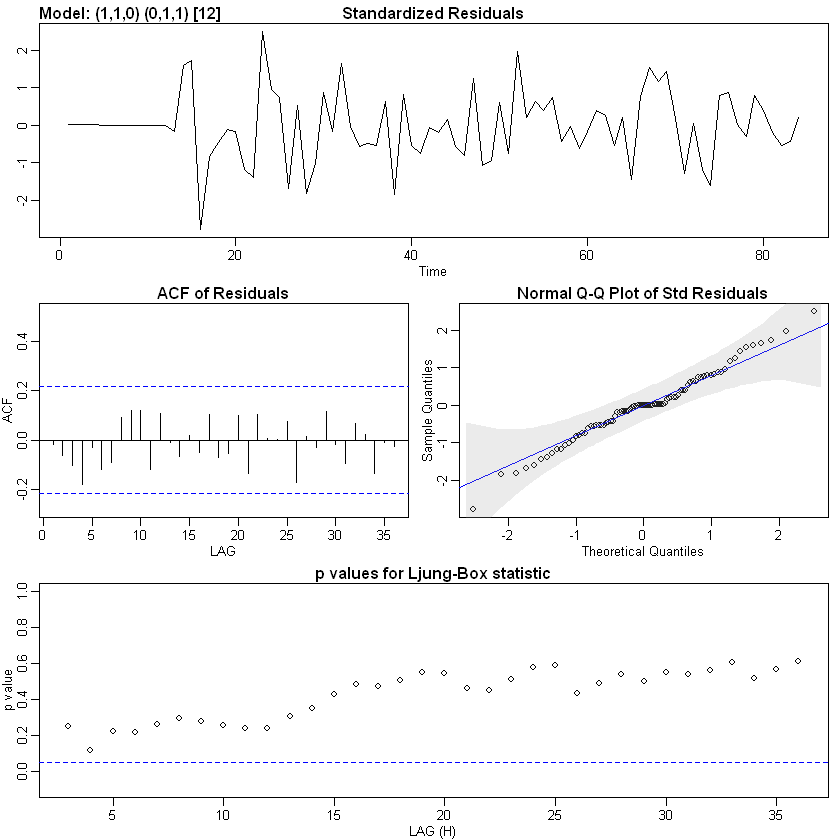

In [73]:
sarima(log(suv),1,1,0,0,1,1,12)

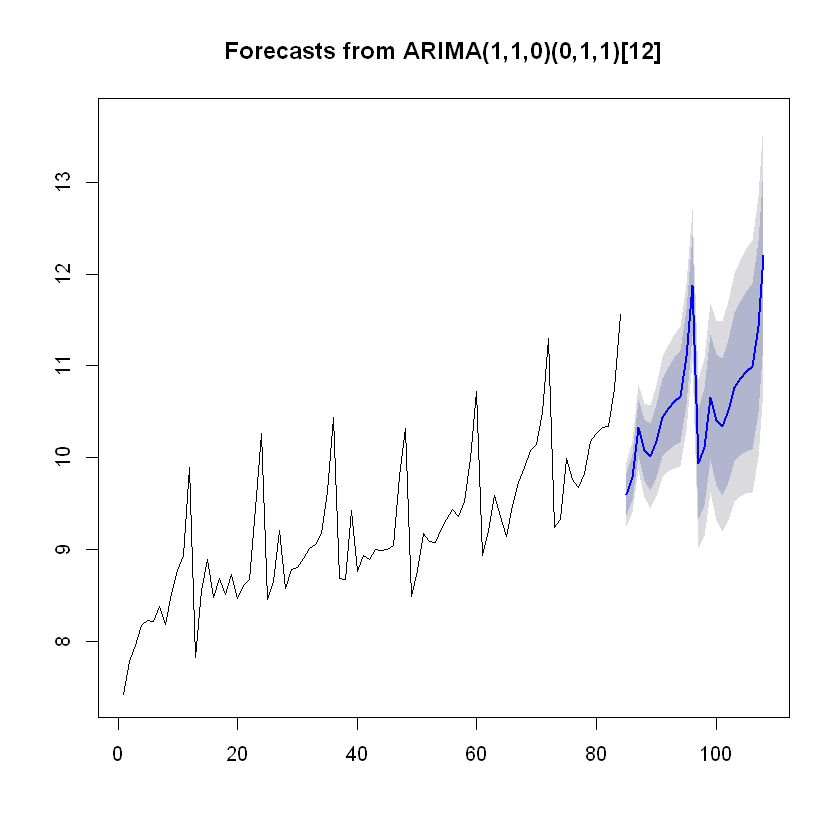

In [74]:
model = arima(x=log(suv), order = c(1,1,0), seasonal = list(order=c(0,1,1), period=12))

plot(forecast(model))

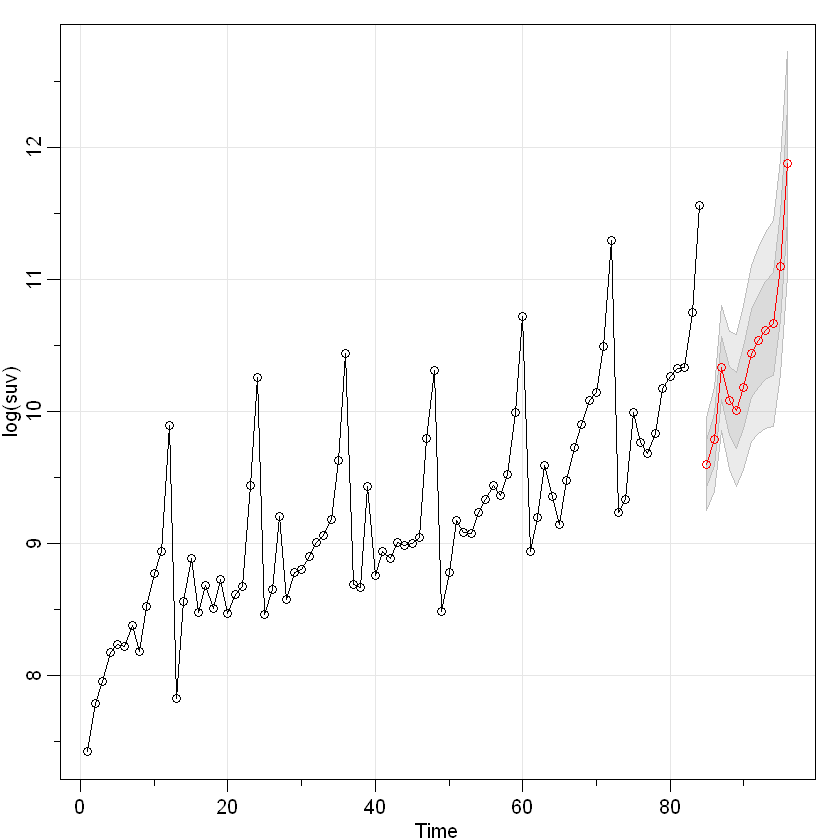

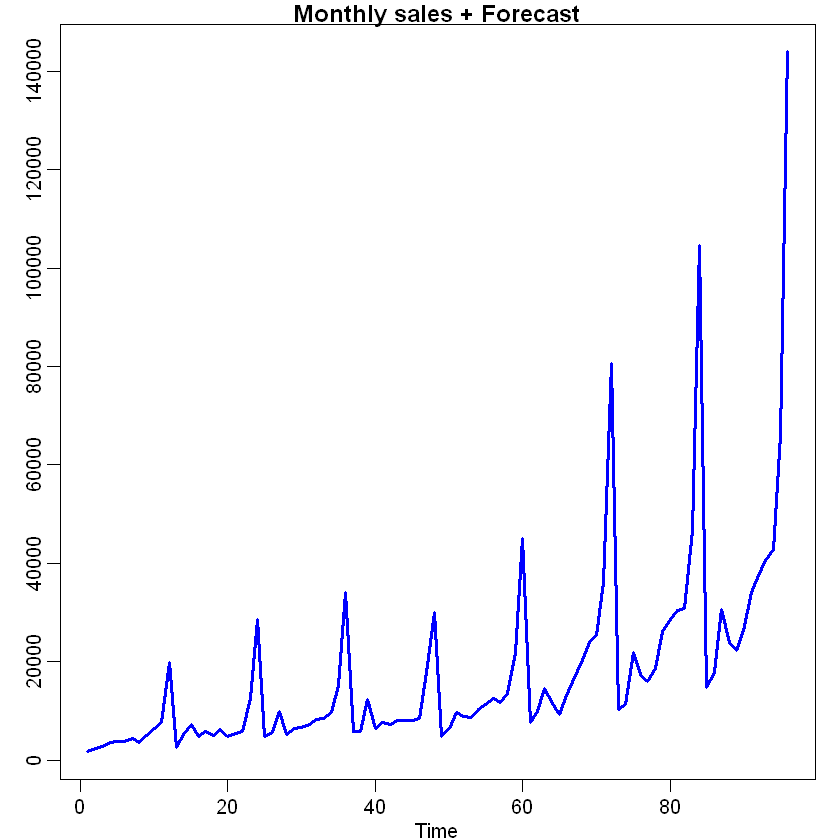

In [78]:
a = sarima.for(log(suv),12,1,1,0,0,1,1,12)

plot.ts(c(suv,exp(a$pred)), main='Monthly sales + Forecast', ylab='', col='blue', lwd=3)